In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os

In [23]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import glob
import logging
import time

import cvnn
import cvnn_custom.complex_ptychonn as cpnn
import cvnn_custom.mixed_ptychonn as mpnn
import cvnn_custom.utils as cutils
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from cvnn_custom.trainer import Trainer
from tensorflow.keras import mixed_precision
from tqdm.notebook import tqdm as tqdm

# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1, 2, 3'
# from skimage.transform import resize


# import pandas


# from plot_utils import plot3
# import h5py

# import ptychodata.utils as exp_utils


# import hiddenlayer as hl

# import sys
# sys.path.append('/home/skandel/code/PtychoNN/common_utils')

# import loadings, stitching, plot_utils
# from skimage.metrics import structural_similarity as ssim, normalized_root_mse as mse

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

tf.get_logger().setLevel(logging.ERROR)

In [24]:
plt.style.use("seaborn-white")
# matplotlib.rc('xtick', labelsize=20)
# matplotlib.rc('ytick', labelsize=20)
matplotlib.rc("font", family="Times New Roman")
matplotlib.rcParams["font.size"] = 20
plt.viridis()

/tmp/ipykernel_486245/2740486998.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


<Figure size 640x480 with 0 Axes>

In [25]:
# print(os.environ["CUDA_VISIBLE_DEVICES"])
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [26]:
if len(gpus):
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Restricting Memory")
    except RuntimeError as e:
        print(e)
    policy = mixed_precision.Policy("mixed_float16")
    mixed_precision.set_global_policy(policy)

Restricting Memory
Restricting Memory
Restricting Memory
Restricting Memory


In [27]:
if len(tf.config.list_physical_devices("GPU")) > 1:
    strategy = tf.distribute.MirroredStrategy()
else:  # Use the Default Strategy
    strategy = tf.distribute.get_strategy()

In [28]:
EPOCHS = 10
N_TRAIN_RUNS = 1
CHECKPOINT_FREQUENCY = 25
NGPUS = len(tf.config.list_physical_devices("GPU"))
BATCH_SIZE = NGPUS * 64
LR = 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 4 Batch size: 256 Learning rate: 0.001


In [29]:
inner_dirname_prefix = f"full_complex"
output_suffix = ""

### Creating and training (from scratch) the new model

In [ ]:
def loadTrainingData(ds):
    with h5py.File(f"{data_path}/reduced_train_{ds}_128.h5") as f:
        X_train = np.array(f["diffr"])
        Y_train = np.array(f["obj"])
        pos_row_train = np.array(f["pos/x_int"]).flatten()
        pos_col_train = np.array(f["pos/y_int"]).flatten()
    return X_train, Y_train

In [32]:
def setupTrainingRun(out_path, suffix, X_train, Y_train, model_type="complex", verbose=True):
    with strategy.scope():
        if model_type == "complex":
            model = cpnn.create_model_64_to_128(img_h=64, img_w=64)
        elif model_type == "mixed":
            model = mpnn.create_model_64_to_128(img_h=64, img_w=64)
        elif model_type == "mixed_reduced":
            raise NotImplementedError

        trainer = Trainer(model, batch_size=BATCH_SIZE, output_path=out_path, output_suffix=suffix)
        trainer.setTrainingData(X_train, Y_train)
        trainer.setOptimizationParams()
        trainer.initModel(verbose=verbose)
    return trainer


def runModel(trainer, epochs=EPOCHS, checkpoint_frequency=25, output_frequency=5):
    with strategy.scope():
        trainer.initTrainingRun(
            early_stop_patience=50,
            early_stop_loss="loss",
            overwrite_history=False,
            extra_checkpoint_frequency=checkpoint_frequency,
        )

    trainer.run(epochs)

In [33]:
model = cpnn.create_model_128_to_128()

In [20]:
X_train, Y_train = loadTrainingData(data_size)

### Trying the complex model first 

[<KerasTensor: shape=(None, 64, 64, 1) dtype=complex64 (created by layer 'input_6')>, <KerasTensor: shape=(None, 64, 64, 32) dtype=complex64 (created by layer 'dl_0_conv0')>, <KerasTensor: shape=(None, 64, 64, 32) dtype=complex64 (created by layer 'dl_0_conv1')>, <KerasTensor: shape=(None, 32, 32, 64) dtype=complex64 (created by layer 'dl_1_dconv0')>, <KerasTensor: shape=(None, 32, 32, 64) dtype=complex64 (created by layer 'dl_1_conv1')>, <KerasTensor: shape=(None, 16, 16, 128) dtype=complex64 (created by layer 'dl_2_dconv0')>, <KerasTensor: shape=(None, 16, 16, 128) dtype=complex64 (created by layer 'dl_2_conv1')>, <KerasTensor: shape=(None, 16, 16, 128) dtype=complex64 (created by layer 'complex_batch_normalization_3')>]
After bottleneck
[<KerasTensor: shape=(None, 8, 8, 128) dtype=complex64 (created by layer 'btn_dconv0')>, <KerasTensor: shape=(None, 8, 8, 128) dtype=complex64 (created by layer 'btn_conv1')>]
LR step size is: 24 which is every 6 epochs
summary for model_3
Model: "mo

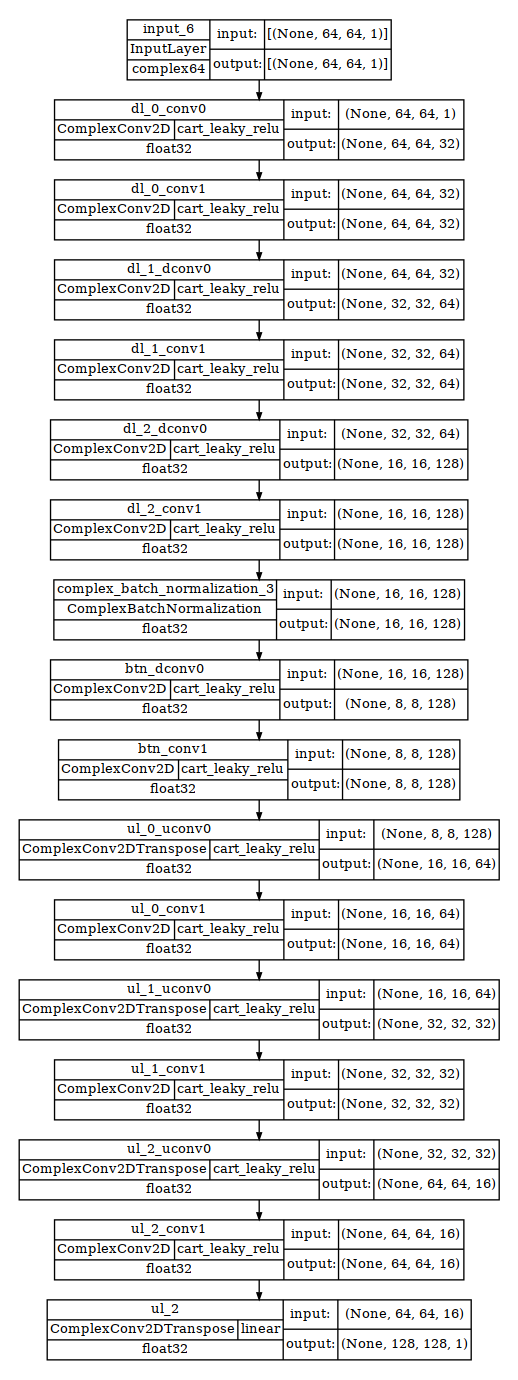

In [27]:
trainer = setupTrainingRun(".", "", X_train, Y_train)

Out directory is ./full_complex_smallest
[<KerasTensor: shape=(None, 64, 64, 1) dtype=complex64 (created by layer 'input_8')>, <KerasTensor: shape=(None, 64, 64, 32) dtype=complex64 (created by layer 'dl_0_conv0')>, <KerasTensor: shape=(None, 64, 64, 32) dtype=complex64 (created by layer 'dl_0_conv1')>, <KerasTensor: shape=(None, 32, 32, 64) dtype=complex64 (created by layer 'dl_1_dconv0')>, <KerasTensor: shape=(None, 32, 32, 64) dtype=complex64 (created by layer 'dl_1_conv1')>, <KerasTensor: shape=(None, 16, 16, 128) dtype=complex64 (created by layer 'dl_2_dconv0')>, <KerasTensor: shape=(None, 16, 16, 128) dtype=complex64 (created by layer 'dl_2_conv1')>, <KerasTensor: shape=(None, 16, 16, 128) dtype=complex64 (created by layer 'complex_batch_normalization_5')>]
After bottleneck
[<KerasTensor: shape=(None, 8, 8, 128) dtype=complex64 (created by layer 'btn_dconv0')>, <KerasTensor: shape=(None, 8, 8, 128) dtype=complex64 (created by layer 'btn_conv1')>]
LR step size is: 24 which is ever

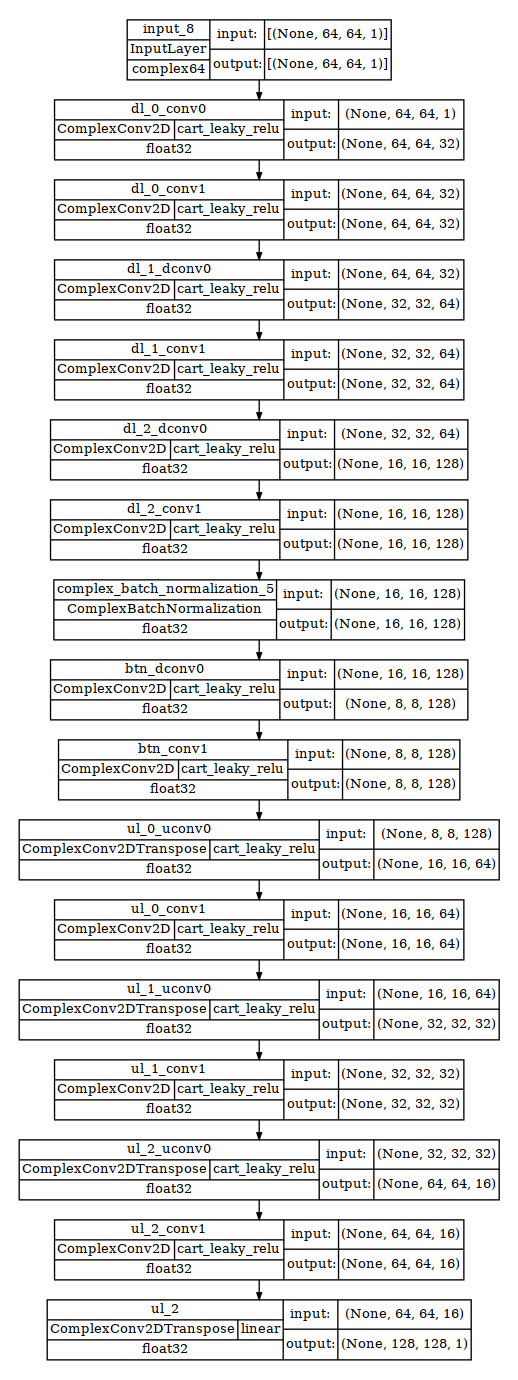

output path is ./full_complex_smallest
True
Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.2276 - lr: 1.3333e-04
Epoch 1: val_loss improved from inf to 0.21308, saving model to ./full_complex_smallest/val_loss_best_model_0-20221227-193637.h5

Epoch 1: loss improved from inf to 0.22764, saving model to ./full_complex_smallest/loss_best_model_0-20221227-193637.h5
Saving history to ./full_complex_smallest/histories_0-20221227-193637
3/3 [==============================] - 30s 2s/step - loss: 0.2276 - lr: 1.3333e-04 - val_loss: 0.2131 - lr_per_epoch: 1.5000e-04
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.2201 - lr: 1.8333e-04
Epoch 2: val_loss improved from 0.21308 to 0.20308, saving model to ./full_complex_smallest/val_loss_best_model_0-20221227-193637.h5

Epoch 2: loss improved from 0.22764 to 0.22010, saving model to ./full_complex_smallest/loss_best_model_0-20221227-193637.h5
Saving history to ./full_complex_smallest/histories_0-20221227-1936

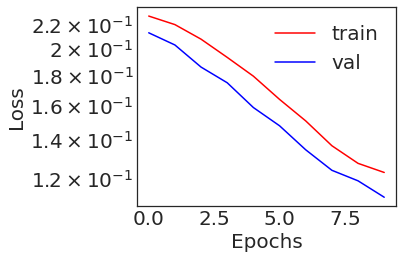

In [30]:
path1 = "."
for i1, ds in enumerate(["smallest"]):
    out_path = path1 + f"/{inner_dirname_prefix}_{ds}"
    if not os.path.isdir(out_path):
        print(f"Not found {out_path}. Creating new directory.")
        os.mkdir(out_path)
    print(f"Out directory is {out_path}")

    X_train, Y_train = loadTrainingData(ds)

    trainers = []
    for nt in range(N_TRAIN_RUNS):
        suff_this = f"{output_suffix}_{nt}"

        verbose = True if (i1 + nt) == 0 else False
        trainer_this = setupTrainingRun(out_path, suff_this, X_train, Y_train, verbose=verbose)

        runModel(trainer_this, EPOCHS, 25, 5)
        trainers.append(trainer_this)

    plt.figure()
    for trainer in trainers:
        plt.plot(np.array(trainer.history.history["loss"]), color="red", label="train")
        plt.plot(np.array(trainer.history.history["val_loss"]), color="blue", label="val")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

### Trying the mixed model

In [31]:
trainer = setupTrainingRun(".", "", X_train, Y_train, model_type="mixed")

AttributeError: module 'cvnn_custom.real_models' has no attribute 'down_block_fn'

Not found ./nb_3_5_nf_32_16_smallest. Creating new directory.
Out directory is ./nb_3_5_nf_32_16_smallest
[<KerasTensor: shape=(None, 64, 64, 1) dtype=complex64 (created by layer 'input_3')>, <KerasTensor: shape=(None, 64, 64, 32) dtype=complex64 (created by layer 'dl_0_conv0')>, <KerasTensor: shape=(None, 32, 32, 32) dtype=complex64 (created by layer 'dl_0_convDown')>, <KerasTensor: shape=(None, 32, 32, 64) dtype=complex64 (created by layer 'dl_1_conv0')>, <KerasTensor: shape=(None, 16, 16, 64) dtype=complex64 (created by layer 'dl_1_convDown')>, <KerasTensor: shape=(None, 16, 16, 128) dtype=complex64 (created by layer 'dl_2_conv0')>, <KerasTensor: shape=(None, 8, 8, 128) dtype=complex64 (created by layer 'dl_2_convDown')>]
After bottleneck
[<KerasTensor: shape=(None, 8, 8, 128) dtype=complex64 (created by layer 'btn_conv0')>, <KerasTensor: shape=(None, 8, 8, 128) dtype=complex64 (created by layer 'btn_conv1')>]
LR step size is: 48 which is every 6 epochs
summary for model_2
Model: "m

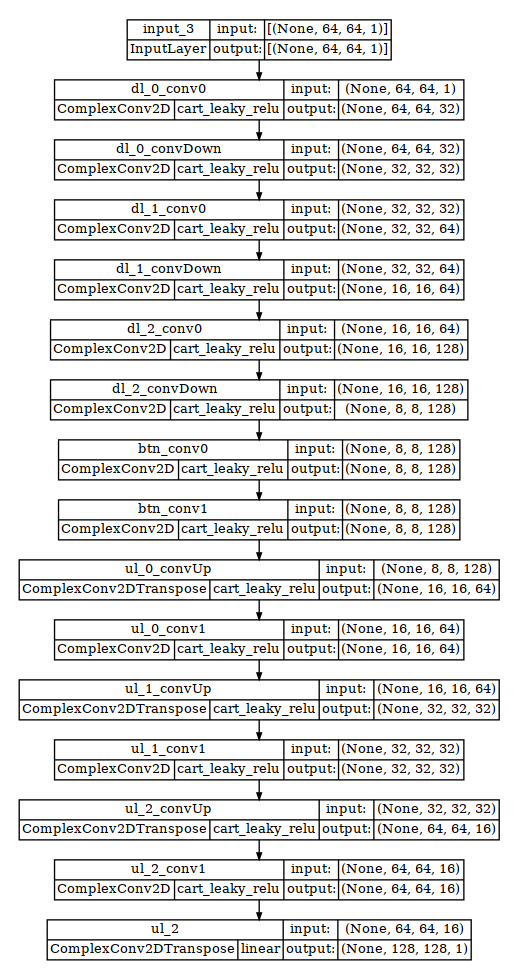

output path is ./nb_3_5_nf_32_16_smallest
True
Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 0.2029 - lr: 1.3333e-04
Epoch 1: val_loss improved from inf to 0.17195, saving model to ./nb_3_5_nf_32_16_smallest/val_loss_best_model_0-20221219-213615.h5

Epoch 1: loss improved from inf to 0.20295, saving model to ./nb_3_5_nf_32_16_smallest/loss_best_model_0-20221219-213615.h5
Saving history to ./nb_3_5_nf_32_16_smallest/histories_0-20221219-213615
7/7 [==============================] - 20s 235ms/step - loss: 0.2029 - lr: 1.3333e-04 - val_loss: 0.1720 - lr_per_epoch: 1.5833e-04
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 0.1631 - lr: 1.9167e-04
Epoch 2: val_loss improved from 0.17195 to 0.14205, saving model to ./nb_3_5_nf_32_16_smallest/val_loss_best_model_0-20221219-213615.h5

Epoch 2: loss improved from 0.20295 to 0.16314, saving model to ./nb_3_5_nf_32_16_smallest/loss_best_model_0-20221219-213615.h5
Saving history to ./nb_3_5_nf_32_16_smallest/h

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


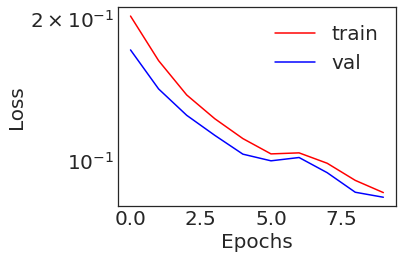

In [33]:
path1 = "."
for i1, ds in enumerate(["smallest"]):
    out_path = path1 + f"/{inner_dirname_prefix}_{ds}"
    if not os.path.isdir(out_path):
        print(f"Not found {out_path}. Creating new directory.")
        os.mkdir(out_path)
    print(f"Out directory is {out_path}")

    X_train, Y_train = loadTrainingData(ds)

    trainers = []
    for nt in range(N_TRAIN_RUNS):
        suff_this = f"{output_suffix}_{nt}"

        verbose = True if (i1 + nt) == 0 else False
        trainer_this = setupTrainingRun(out_path, suff_this, X_train, Y_train, verbose=verbose)

        runModel(trainer_this, EPOCHS, 25, 5)
        trainers.append(trainer_this)

    plt.figure()
    for trainer in trainers:
        plt.plot(np.array(trainer.history.history["loss"]), color="red", label="train")
        plt.plot(np.array(trainer.history.history["val_loss"]), color="blue", label="val")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()